# US Senators dataset

## Students

* Team: `18`
* Students: ` Quentin Bacuet, Ali Alami-Idrissi, Keshav Singh, Leandro Kieliger`
* Dataset: `US-Senators`

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
from scipy import sparse
from pygsp import graphs, reduction
from scipy import linalg
from sklearn.cluster import KMeans
from pyunlocbox import functions, solvers
import networkx as nx
from IPython.display import display, HTML
from pyunlocbox import functions, solvers

from helpers import *
from solver import *

## Load processed data

In [2]:
votes = pd.read_pickle("data/processed/processed_votes.pickle")
print(votes.shape)
display(votes.index)

(105, 18)


Index(['A000360', 'B000575', 'B000944', 'B001135', 'B001230', 'B001236',
       'B001261', 'B001267', 'B001277', 'B001288',
       ...
       'T000464', 'T000476', 'U000039', 'V000128', 'W000437', 'W000779',
       'W000802', 'W000805', 'W000817', 'Y000064'],
      dtype='object', name='member_id', length=105)

## Load labels

## Building the similarity graph

In [3]:
features = [votes.values]
weights = [1]
sparsification_functions = [lambda arg : sparsify_with_limit(sparsify_with_max_neighbors(arg, 6),0.55)]

adjacency = get_adjacency_multidistance(features, weights, cosine_similarity, lambda x:x, sparsification_functions)
senators = pd.read_pickle("data/processed/processed_senators.pickle")
labels_text = senators['party']
labels = np.load("data/processed/processed_labels_numerical.npy")
argsort_labels = np.argsort(labels)

"""
# Remove nodes without neighbors
node_degrees = np.count_nonzero(adjacency, axis=1)
nodes_to_keep = np.nonzero(node_degrees)[0]
adjacency = adjacency[nodes_to_keep,:][:,nodes_to_keep]

labels_kept = labels[nodes_to_keep]
"""

def build_coordinates():
    coord = []
    for a in np.linspace(0, np.pi / 2.0 - 0.3, 10):
        for r in np.linspace(2,7,5): 
            coord.append([r * np.cos(a), r * np.sin(a)])
       
    for a in np.linspace(np.pi / 2.0 + 0.3, np.pi, 11):
        for r in np.linspace(2,7,5):    
            coord.append([r * np.cos(a), r * np.sin(a)])
            
    return coord

coord = np.array(build_coordinates())

[]


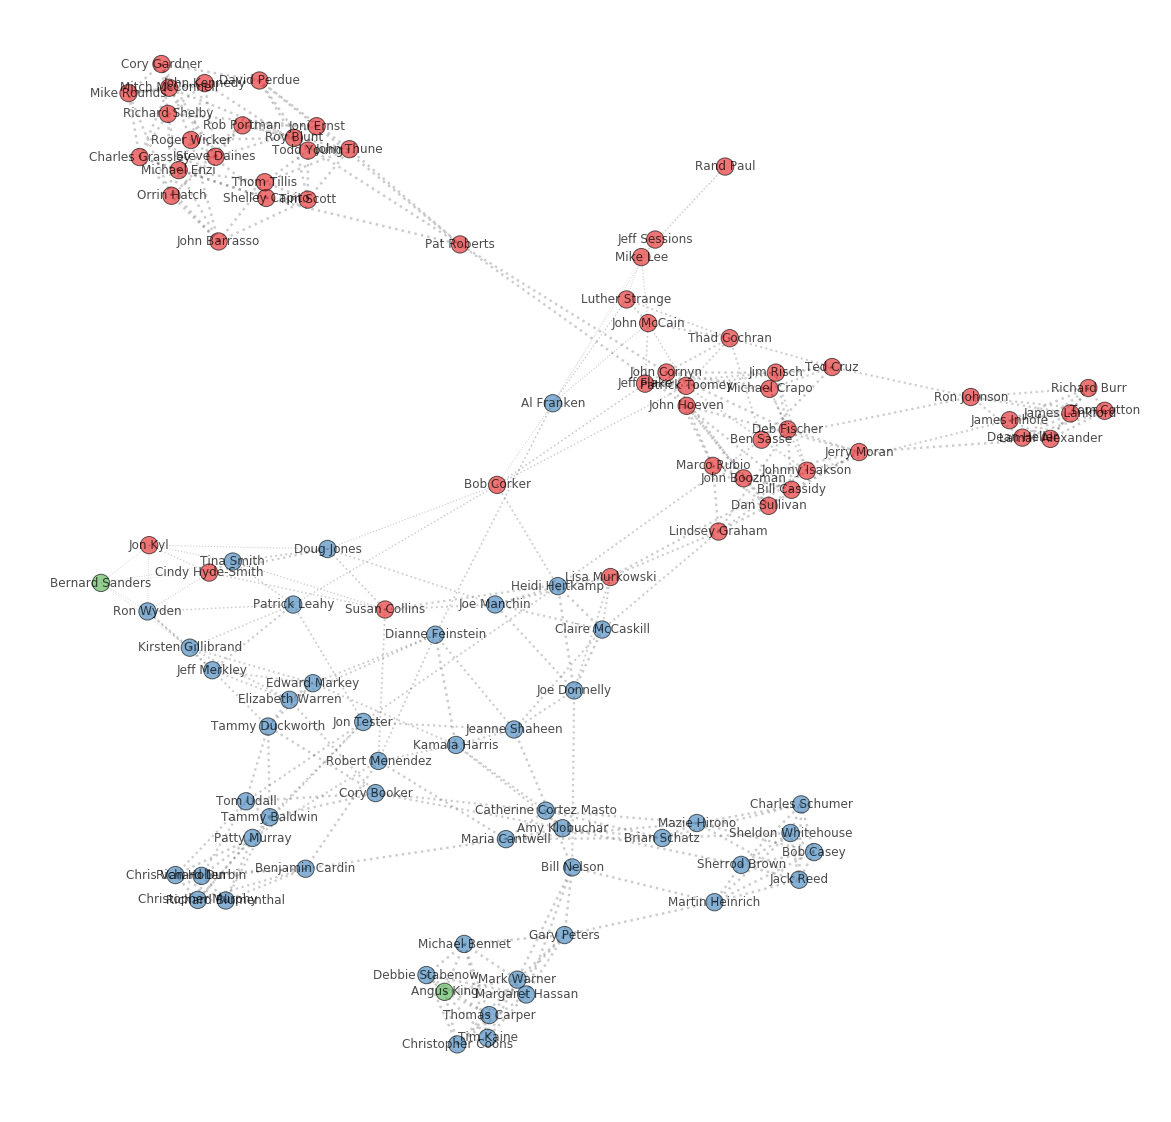

In [5]:
plt.figure(figsize=(20,20))
plot_signal(adjacency, labels, labels=senators['name'], scale=[0,1])

## Embedding you in the graph

In [6]:
bill_selection = [5,10,15]
your_votes = [1,-1,1]

other_senators_vote = votes.values[:,bill_selection]

In [7]:
def compute_similarity(senator_votes):
    return euclidean_distance(senator_votes, your_votes)

similarity_vector = np.apply_along_axis(compute_similarity, 1, other_senators_vote)
similarity_vector = sparsify_with_limit(gaussian_kernel(similarity_vector),0.7)

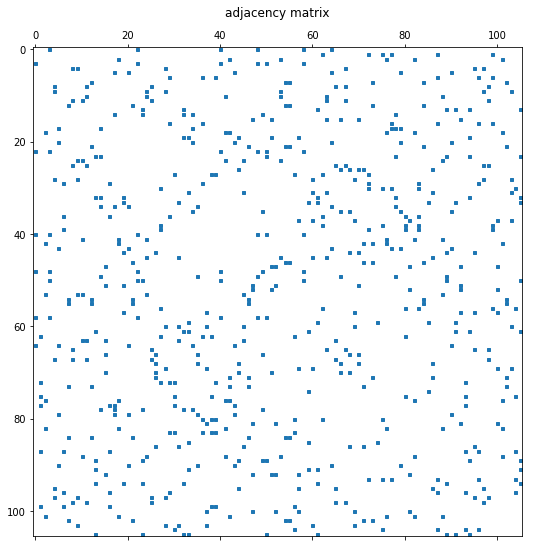

In [8]:
new_columns = np.append(similarity_vector, 0)

n = len(adjacency)
new_adjacency = np.zeros((n+1, n+1))
new_adjacency[:n,:n] = adjacency
new_adjacency[n,:] = new_columns
new_adjacency[:,n] = new_columns

new_labels = np.append(senators['name'].values, ['you'])

plot_adjacency(new_adjacency)

['you']


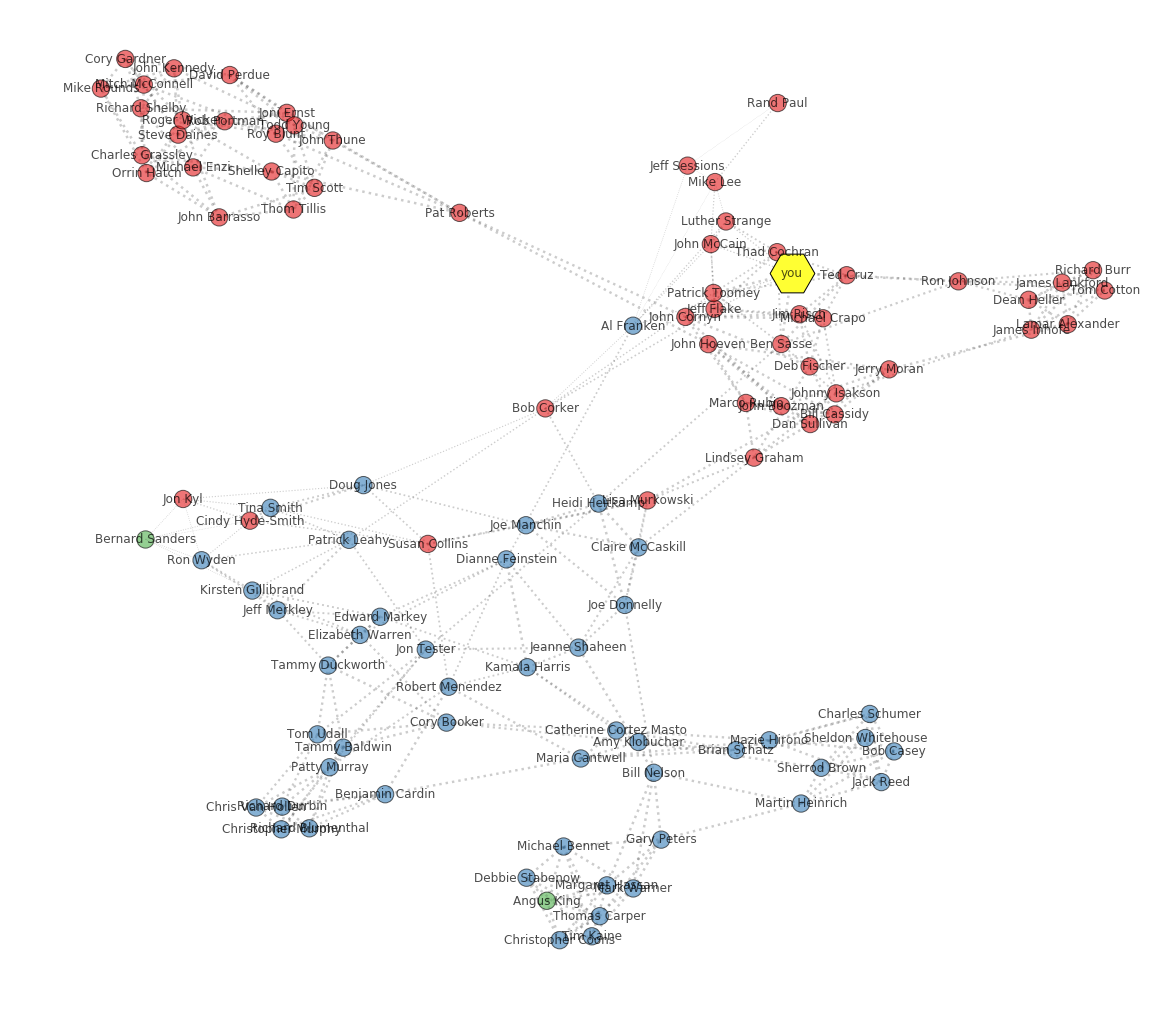

In [9]:
plt.figure(figsize=(20,18))

pos = dict(zip(senators['name'].values[argsort_labels], coord))
pos['you'] = [0,0]

plot_signal(new_adjacency, np.append(labels, [0]), labels=new_labels, scale=[0,1], highlight_node=[105])

## Spectral analysis of the new adjacency matrix

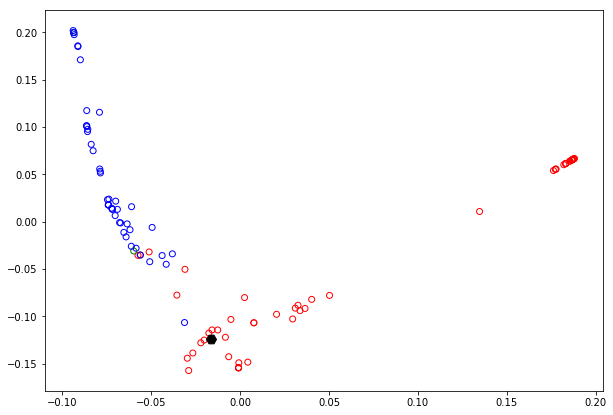

In [10]:
G = graphs.Graph(new_adjacency)
G.set_coordinates('spring', seed=2018)
G.compute_fourier_basis()
G.compute_laplacian()

embedding = G.U[:,1:3]

colors = {'R':'red','D':'blue','I':'green'}

plt.figure(figsize=(10,7))

n = len(embedding)
for i in range(n-1):
    plt.scatter(embedding[i,0], embedding[i,1], facecolors='none', edgecolors=colors[labels_text[i]])
    
plt.scatter(embedding[n-1,0], embedding[n-1,1], color='black', s=100, marker='H')

Text(-0.0198171,-0.15,'You')

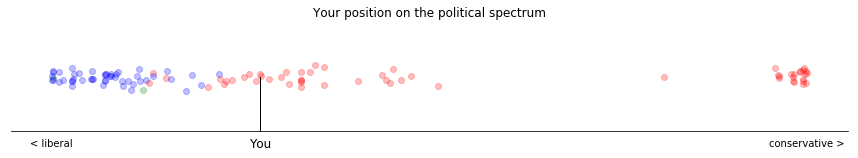

In [11]:
from scipy.stats import gaussian_kde

fig = plt.figure(figsize=(15,2))
ax = plt.subplot(111)
ax.set_title("Your position on the political spectrum")

for i in range(n-1):
    ax.scatter(embedding[i,0], np.random.normal(.5,.05), alpha=0.25, color=colors[labels_text[i]])
    
#ax.scatter(embedding[n-1,0], embedding[n-1,1], color='black', s=100, marker='H')
density = gaussian_kde(embedding[:,0])
xs = np.linspace(np.min(embedding[:,0]),np.max(embedding[:,0]),100)


#ax.plot(xs, density(xs))
ax.set_xticks([np.min(embedding[:,0]),np.max(embedding[:,0])])
ax.set_ylim([0,1])
ax.set_xticklabels(['< liberal','conservative >'])
plt.tick_params(axis='x', which='both', bottom=False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot([embedding[n-1,0], embedding[n-1,0]], [0, 0.5], 'k-', lw=1)

plt.text(embedding[n-1,0] - 0.0035, -0.15, "You", fontsize=12)

# Predicting votes based on votes from similar senators

[]


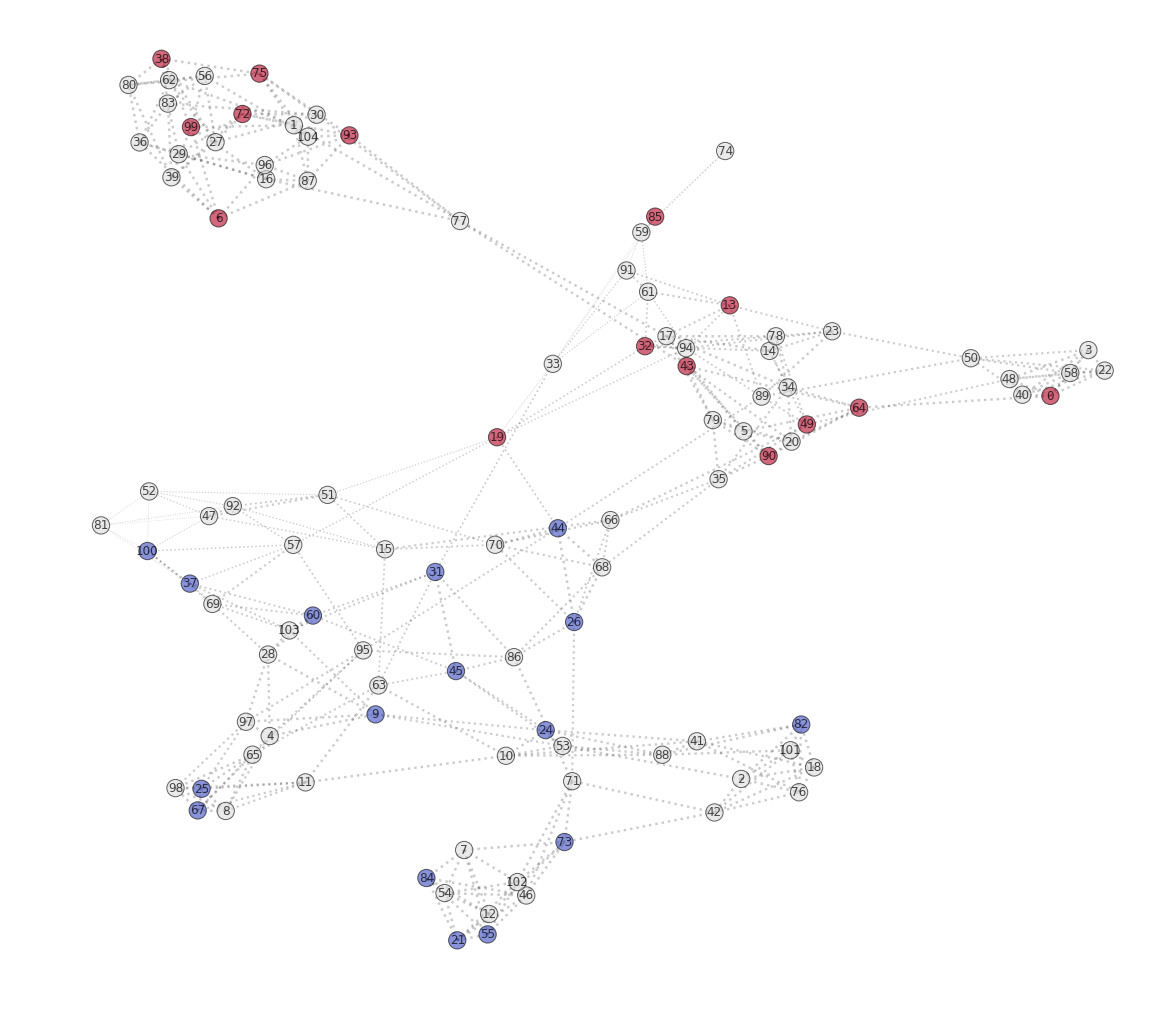

In [19]:
# Binarize labels
labels_bin = labels.copy()
labels_bin[labels > 0.1] = -1
labels_bin[labels <= 0.1] = 1
labels_bin

n = len(labels)

mn_ratio = 0.3 # Ratio of node labels to keep
m = int(mn_ratio * n)  # Number of measurements.

def get_mask(m):
    idx = np.random.choice(np.arange(n),m,replace=False)
    w = np.zeros(n)
    w[idx] = 1
    return w

w = get_mask(m)

plt.figure(figsize=(20,18))
plot_signal(adjacency, w*labels_bin, scale=[-1,1], colormap=plt.get_cmap('coolwarm'))

In [20]:
G = graphs.Graph(adjacency)
G.set_coordinates('spring', seed=2018)
G.compute_fourier_basis()
G.compute_differential_operator()
G.compute_laplacian()

sol_2norm_min = graph_pnorm_interpolation(sparse.csr_matrix(G.D),P_wrapper(w, labels_bin),np.random.randn(n),2)

threshold = 0

sol_2norm_bin = get_thresholded_values(sol_2norm_min,threshold)

Solution found after 200 iterations:
    objective function f(sol) = 3.556127e+01
    stopping criterion: MAXIT


0.4364357804719848
[]


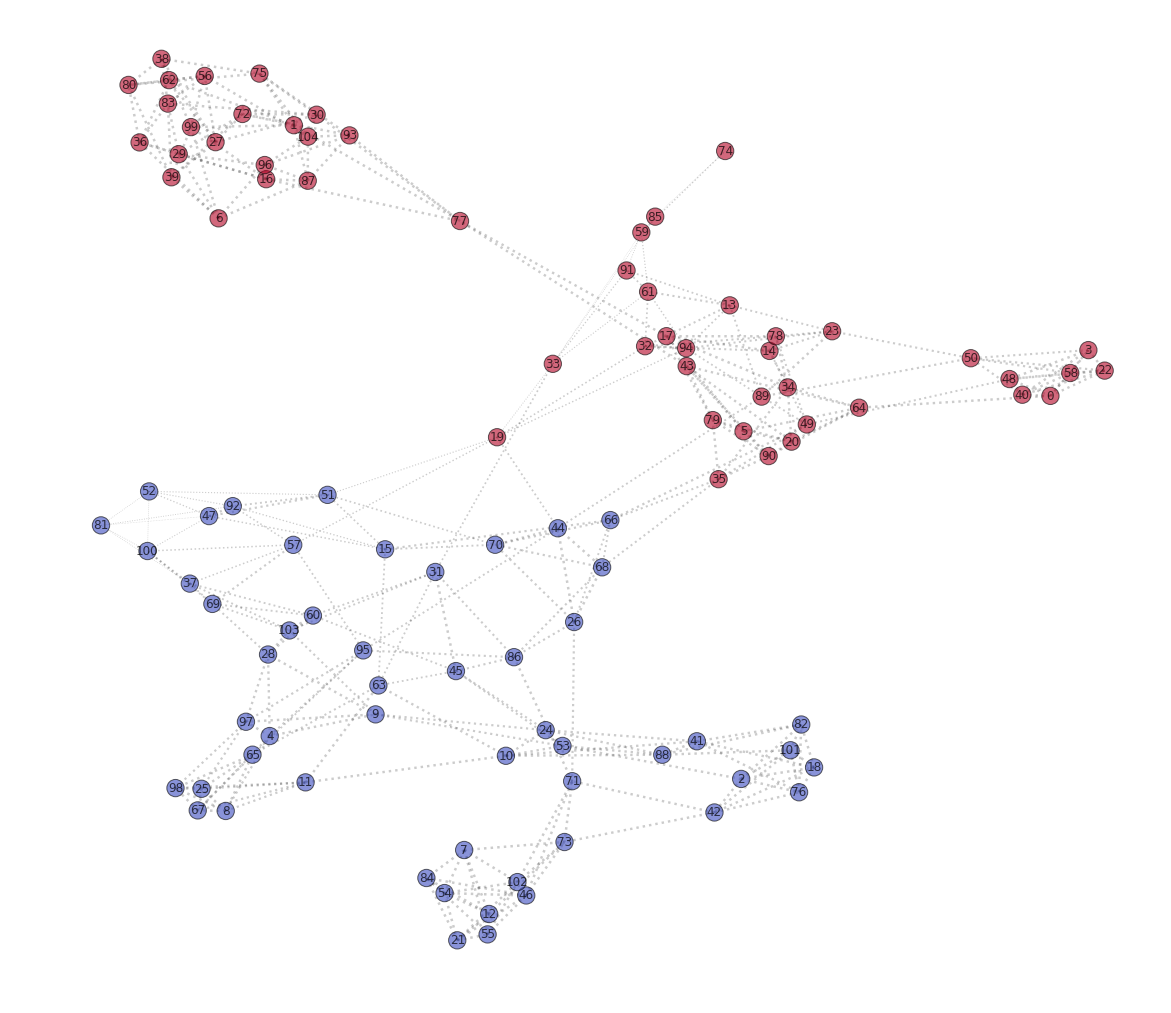

In [21]:
plt.figure(figsize=(20,18))
print(error(labels_bin, sol_2norm_bin))
plot_signal(adjacency, sol_2norm_bin, scale=[-1,1], colormap=plt.get_cmap('coolwarm'))

# What about you ?

# Going further, can we predict the voting outcome based on votes of swing senators ?

Swing senators are those thank link the democratic and republican clusters